In [10]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import re
import sys
import time
from typing import *
import warnings
warnings.filterwarnings("ignore")


##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf


##  IMPORT DATA PIPELINE PIECES

path_sdp = "/Users/usuario/git/sisepuede_data_pipeline"
if path_sdp not in sys.path:
    sys.path.append(path_sdp)

import lib.data_objects as do


In [265]:
import sisepuede.manager.sisepuede_file_structure as sfs
importlib.reload(sfs.ma.mv)
importlib.reload(sfs.ma)
file_struct = sfs.SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

<module 'sisepuede.core.model_attributes' from '/opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/core/model_attributes.py'>

In [375]:
##  SETUP SOME SISEPUEDE STUFF

file_struct = sfs.SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)



##  SETUP DIRECTORIES

dir_cur = pathlib.Path(os.getcwd())
dir_data = dir_cur.joinpath("data")
dir_transformations = dir_cur.joinpath("transformations")


##  SETUP FILES

fp_data_base = dir_data.joinpath("sisepuede_inputs_iran_raw.csv")
fp_data_inputs = dir_data.joinpath("sisepuede_inputs_iran.csv")
fp_data_inputs_modified = dir_data.joinpath("sisepuede_inputs_iran_modified.csv")

fp_cw_iea_fuel_to_ssp = pathlib.Path(file_struct.dir_ref).joinpath("data_crosswalks", "iea_fuel_categories.csv")



In [12]:
##  BUILD BASE INPUTS

df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

# Review fields that are missing

In [13]:
[
    x for x in df_inputs_example.columns if x not in df_inputs_raw.columns
]

['region',
 'ef_enfu_combustion_tonne_co2_per_tj_fuel_water',
 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_water',
 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_water',
 'strategy_id',
 'cost_enfu_fuel_ammonia_usd_per_tonne',
 'ef_enfu_combustion_tonne_co2_per_tj_fuel_ammonia',
 'ef_trns_mobile_combustion_water_borne_kg_n2o_per_tj_ammonia',
 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_ammonia',
 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_ammonia',
 'exports_enfu_pj_fuel_ammonia',
 'frac_enfu_fuel_demand_imported_pj_fuel_ammonia',
 'nemomod_entc_capital_cost_fp_ammonia_production_mm_usd_per_gw',
 'nemomod_entc_capital_cost_fp_hydrogen_reformation_ccs_mm_usd_per_gw',
 'nemomod_entc_emissions_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_tonne_co2_per_tj',
 'nemomod_entc_emissions_activity_ratio_scalar_fp_hydrogen_reformation_ccs_co2',
 'nemomod_entc_fixed_cost_fp_ammonia_production_mm_usd_per_gw',
 'nemomod_entc_fixed_cost_fp_hydrogen_refo

###   Build the file here

- Drop unecessary fields
- Use systematic keys/index fields
- add region name

In [14]:
##  SOME MANUAL FIXES FOR THE MOMENT

df_inputs_example["exports_enfu_pj_fuel_ammonia"] = 0


fields_drop_example = [
    x for x in [regions.key, matt.dim_strategy_id]
    if x in df_inputs_example
]

fields_drop_raw = [
    x for x in ["iso_code3", "Year"]
    if x in df_inputs_example
]

df_inputs = sf.match_df_to_target_df(
    df_inputs_example
    .drop(
        columns = fields_drop_example,
    ),
    df_inputs_raw
    .drop(
        columns = fields_drop_raw,
    ),
    [time_periods.field_time_period],
    overwrite_only = False,
)

df_inputs[regions.key] = "iran"

# Load datasets
- These can be moved to an `InputsReader` object

In [378]:
# build some shared objs
iea_info = do.DatasetIEA(None)
FIELD_IEA_FUEL_TMP = "Fuel"
FIELD_IEA_TECH_TMP = "Tech"



# set a regex and read those that match into a dictionary
regex_match = re.compile("International Energy Agency - (.*\D).csv")
files_read = [
    x for x in os.listdir(dir_data) if regex_match.match(x) is not None
]

dict_files = {}

for x in files_read:

    fp = dir_data.joinpath(x)
    field = regex_match.match(x).groups()[0]
    nm = field.replace(" in Iran", "")

    df = pd.read_csv(fp)
    dict_files.update({nm: df})

    

##  Build some dictionaries that we need

In [391]:

######
#    SOME DICTIONARIES    #
##

def get_iea_fuel_to_entc_pp_dicts(
    model_attributes: 'ModelAttributes',
    attribute_field_fuel: str = "electricity_generation_cat_fuel",
    flag_ccs: str = "_ccs",
) -> Tuple[dict, dict]:
    """
    Retrieve dictionaries mapping 

        1. ENTC power plant categories to fuels
        2. ENFU categories to applicable techs for allocation from
            IEA data. NOTE: excludes ccs

    Function Arguments
    ------------------
    - model_attributes: model attributes object
    
    Keyword Arguments
    -----------------
    - attribute_field_fuel: field in the technology attribute table
        storing the fuel used by entc 
    - flag_ccs: flag in ENTC categories used to denote CCS
    """
    # retrieve attribute tables
    attr_enfu = model_attributes.get_attribute_table(matt.subsec_name_enfu, )
    attr_entc = matt.get_attribute_table(matt.subsec_name_entc, )
    
    dict_entc_cat_to_fuel = dict(
        (
            x, 
            sfs.ma.clean_schema(
                attr.get_attribute(x, attribute_field_fuel)
            )
        )
        for x in attr.key_values
    )

    # get the dictionary mapping ENTC power plants to fueld
    dict_entc_pp_cat_to_enfu_cat = dict(
        (k, v) for k, v in dict_entc_cat_to_fuel.items() 
        if v in attr_enfu.key_values
    )

    # reverse it and drop ccs from our IEA allocation for now
    dict_enfu_cat_to_entc_pp_cat = sf.reverse_dict(
        dict_entc_pp_cat_to_enfu_cat,
        allow_multi_keys = True,
        force_list_values = True,
    )
    dict_enfu_cat_to_entc_pp_cat = dict(
        (k, [x for x in v if flag_ccs not in v][0]) 
        for k, v in dict_enfu_cat_to_entc_pp_cat.items()
        
    )
    
    out = (
        dict_entc_pp_cat_to_enfu_cat,
        dict_enfu_cat_to_entc_pp_cat,
    )

    return out


# get the crosswalk mapping IEA techs to SISEPUEDE techs

def build_dictionaries_iea_to_ssp(
    df_cw: pd.DataFrame,
    model_attributes: 'ModelAttributes',
    **kwargs,
) -> Tuple[dict]:
    """
    Build dictionaries used in crosswalks. Builds the following 
        dictionaries (in order of output tuple):

        * dict_iea_fuel_to_enfu_cat
        * dict_entc_pp_cat_to_enfu_cat
        * dict_enfu_cat_to_entc_pp_cat

    Function Arguments
    ------------------
    - model_attributes: model attributes object
    
    Keyword Arguments
    -----------------
    - **kwargs: passed to get_iea_fuel_to_entc_pp_dicts
    """

    # get dicitionary mapping fuels to ENTC power plants
    (
        dict_entc_pp_cat_to_enfu_cat,
        dict_enfu_cat_to_entc_pp_cat
    ) = get_iea_fuel_to_entc_pp_dicts(
        model_attributes,
        **kwargs,
    )

    # map 
    dict_iea_fuel_to_enfu_cat = sf.build_dict(
        df_cw[
            [
                "iea_fuel",
                matt.get_subsector_attribute(
                    matt.subsec_name_enfu, 
                    "primary_category",
                )
            ]
        ]
    )

    # clean the fields
    dict_iea_fuel_to_enfu_cat = dict(
        (k, sfs.ma.clean_schema(v)) 
        for k, v in dict_iea_fuel_to_enfu_cat.items()
    )

    dict_iea_fuel_to_entc_cat = dict(
        (k, dict_enfu_cat_to_entc_pp_cat.get(v))
        for k, v in dict_iea_fuel_to_enfu_cat.items() 
    )

    dict_iea_fuel_to_entc_cat = dict(
        (k, v) for k, v in dict_iea_fuel_to_entc_cat.items()
        if v is not None
    )

    # return dicts
    out = (
        dict_entc_pp_cat_to_enfu_cat,
        dict_enfu_cat_to_entc_pp_cat,
        dict_iea_fuel_to_enfu_cat,
        dict_iea_fuel_to_entc_cat,
    )

    return out


df_cw = pd.read_csv(fp_cw_iea_fuel_to_ssp)
(
    dict_entc_pp_cat_to_enfu_cat,
    dict_enfu_cat_to_entc_pp_cat,
    dict_iea_fuel_to_enfu_cat,
    dict_iea_fuel_to_entc_cat,
) = build_dictionaries_iea_to_ssp(
    df_cw,
    matt,
)

In [ ]:
importlib.reload(sfs.ma.mv.sf)
importlib.reload(sfs.ma.mv)
importlib.reload(sfs.ma)
importlib.reload(sfs)
file_struct = sfs.SISEPUEDEFileStructure()
matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

# Build MinShareProduction

In [388]:
#
#    DEFINE FUNCTIONS FOR SINGLE REGION, CAN BE EXPANDED TO MULTIPLE REGIONS
#

def aggregate_and_pivot_iea_fuel_single_region(
    dict_files: dict,
    key_dict: str,# = "electricity generation sources",
    modvar: Union[str, 'ModelVariable'],# = "NemoMod MinShareProduction",
    model_attributes: 'ModelAttributes',
    time_periods: sc.TimePeriods,
    regions: sc.Regions,
    calculate_proportion: bool = False,
    cats_keep: Union[List[str], None] = None,
    dataset_iea: do.DatasetIEA = iea_info,
    dict_cat_repl: Union[dict, None] = None,
    field_tech: str = FIELD_IEA_TECH_TMP,
) -> pd.DataFrame:
    """
    Build the minimum share of production data from country profile data


    Function Arguments
    ------------------
    - dict_files: dictionary containing IEA files
    - key_dict: key in the dictionary; also assumed to be a component of
        the field storing fuels
    - modvar: name of variable to assign or ModelVariable object
    
    Keyword Arguments
    -----------------
    - calculate_proportion: calculate the value as a proportion?
    - cats_keep: optional specification of categories (POST replacement) to keep
    - dataset_iea: DatasetIEA object used for field access etc.
    - dict_cat_repl: optional dictionary used to replace fuel categories
        with others
    - field_tech: field used to generate technologies
    """

    df = (
        dict_files
        .get(key_dict)
        .copy()
    )
    field_fuel_to_replace = [x for x in df.columns if (key_dict in x)]
    if len(field_fuel_to_replace) == 0:
        return None

    
    (
        df
        .rename(
            columns = {
                field_fuel_to_replace[0]: field_tech,
            },
            inplace = True,
        )
    )


    ##  GROUP BY YEAR AND BUILD SHARES

    if calculate_proportion:
        df_msp_iea = []
    
        dfg = df.groupby([dataset_iea.field_year])
        for yr, df in dfg:
            yr = yr[0]
    
            df[dataset_iea.field_value] = df[dataset_iea.field_value]/df[dataset_iea.field_value].sum()
            df.drop(
                columns = [
                    dataset_iea.field_units,
                ],
                inplace = True,
            )
    
            df_msp_iea.append(df)

        df_msp_iea = pd.concat(df_msp_iea, )
        
    
    ##  CONCATENATE, CLEAN CATEGORIES, AND AGGREGATE
    
    modvar = matt.get_variable(modvar, )
    subsec = matt.get_variable_subsector(modvar, )
    attr_subsec = matt.get_attribute_table(subsec, )
    dict_cats_to_field = model_attributes.get_category_replacement_field_dict(modvar, )

    # categories to keep
    cats_keep = (
        [x for x in attr_subsec.key_values if x in cats_keep]
        if sf.islistlike(cats_keep)
        else attr_subsec.key_values
    )
    # fields to keep
    fields_universe = [dict_cats_to_field.get(x) for x in cats_keep] 
    
    if isinstance(dict_cat_repl, dict):
        df_msp_iea[field_tech].replace(dict_tech_repl, inplace = True, )
        
    df_msp_iea[field_tech].replace(dict_cats_to_field, inplace = True, )

    # aggregate by tech/year
    df_msp_iea = (
        df_msp_iea
        .fillna(0.0)
        .groupby([field_tech, dataset_iea.field_year])
        .sum()
        .reset_index(drop = False)
    )


    ##  REFORMATTING TO WIDE BY FIELD

    df_msp_iea = sf.pivot_df_clean(
        df_msp_iea,
        [field_tech],
        [dataset_iea.field_value]
    )

    df_msp_iea = (
        time_periods
        .years_to_tps(
            df_msp_iea,
            field_year = dataset_iea.field_year,
        )
        .drop(columns = [dataset_iea.field_year])
    )

    
    # get as a variable and use "any_fill" method to pull all--then, filter on power plants only
    fields_additional = [
        x for x in model_attributes.sort_ordered_dimensions_of_analysis
        if x in df_msp_iea.columns
    ]
    
    df_msp_iea = (
        modvar
        .get_from_dataframe(
            df_msp_iea,
            extraction_logic = "any_fill",
            fields_additional = fields_additional,
            fill_value = 0.0,
        )
        .get(fields_additional + fields_universe)
    )


    ##  FINALLY, MERGE TO ALL TIME PERIODS AND INTERPOLATE WHERE NEEDED

    df_msp_iea = (
        pd.merge(
            time_periods.get_time_period_df(),
            df_msp_iea,
            how = "left",
        )
        .interpolate(method = "bfill")
        .interpolate(method = "ffill")
    )

    
    return df_msp_iea


def build_msp_for_single_region(
    dict_files: dict,
    dict_tech_repl: dict,
    model_attributes: 'ModelAttributes',
    time_periods: sc.TimePeriods,
    regions: sc.Regions,
    dataset_iea: do.DatasetIEA = iea_info,
    field_tech: str = FIELD_IEA_TECH_TMP,
    key_dict: str = "electricity generation sources",
    modvar: Union[str, 'ModelVariable'] = "NemoMod MinShareProduction",
) -> pd.DataFrame:
    """
    Build the minimum share of production data from country profile data


    Function Arguments
    ------------------
    - dict_files: dictionary with IEA country profile files read in
    - dict_tech_repl: dictionary replacing IEA techs with SSP techs

    Keyword Arguments
    -----------------
    - dataset_iea: DatasetIEA object used for field access etc.
    - field_tech: field used to generate technologies
    - key_dict: key in `dict_files` storing data of interest
    - modvar: name of variable to assign or ModelVariable object
    """
    # get the df and check for fields to replace
    df_electricity_generation_share = dict_files.get(key_dict).copy()

    field_fuel_to_replace = [
        x for x in df_electricity_generation_share.columns if (key_dict in x)
    ]
    if len(field_fuel_to_replace) == 0:
        return None

    
    (
        df_electricity_generation_share
        .rename(
            columns = {
                field_fuel_to_replace[0]: field_tech,
            },
            inplace = True,
        )
    )


    ##  GROUP BY YEAR AND BUILD SHARES

    df_msp_iea = []

    dfg = df_electricity_generation_share.groupby([dataset_iea.field_year])
    for yr, df in dfg:
        yr = yr[0]

        df[dataset_iea.field_value] = df[dataset_iea.field_value]/df[dataset_iea.field_value].sum()
        df.drop(
            columns = [
                dataset_iea.field_units,
            ],
            inplace = True,
        )

        df_msp_iea.append(df)

    
    ##  CONCATENATE, CLEAN CATEGORIES, AND AGGREGATE
    
    df_msp_iea = pd.concat(df_msp_iea, )
    modvar = matt.get_variable(modvar, )
    dict_cats_to_field = model_attributes.get_category_replacement_field_dict(modvar, )

    # categories to keep
    cats_keep = matt.filter_keys_by_attribute(
        matt.subsec_name_entc,
        {
            "power_plant": 1
        }
    )
    # fields to keep
    fields_universe = [dict_cats_to_field.get(x) for x in cats_keep] 
        
    df_msp_iea[field_tech] = (
        df_msp_iea[field_tech]
        .replace(dict_tech_repl, ) 
        .replace(dict_cats_to_field, )
    )

    # aggregate by tech/year
    df_msp_iea = (
        df_msp_iea
        .fillna(0.0)
        .groupby([field_tech, dataset_iea.field_year])
        .sum()
        .reset_index(drop = False)
    )


    ##  REFORMATTING TO WIDE BY FIELD

    df_msp_iea = sf.pivot_df_clean(
        df_msp_iea,
        [field_tech],
        [dataset_iea.field_value]
    )

    df_msp_iea = (
        time_periods
        .years_to_tps(
            df_msp_iea,
            field_year = dataset_iea.field_year,
        )
        .drop(columns = [dataset_iea.field_year])
    )

    
    # get as a variable and use "any_fill" method to pull all--then, filter on power plants only
    fields_additional = [
        x for x in model_attributes.sort_ordered_dimensions_of_analysis
        if x in df_msp_iea.columns
    ]
    
    df_msp_iea = (
        modvar
        .get_from_dataframe(
            df_msp_iea,
            extraction_logic = "any_fill",
            fields_additional = fields_additional,
            fill_value = 0.0,
        )
        .get(fields_additional + fields_universe)
    )


    ##  FINALLY, MERGE TO ALL TIME PERIODS AND INTERPOLATE WHERE NEEDED

    df_msp_iea = (
        pd.merge(
            time_periods.get_time_period_df(),
            df_msp_iea,
            how = "left",
        )
        .interpolate(method = "bfill")
        .interpolate(method = "ffill")
    )

    
    return df_msp_iea


df_msp = build_msp_for_single_region(
    dict_files,
    dict_iea_fuel_to_entc_cat,
    matt,
    time_periods,
    regions,
)

In [346]:
# PULL IN MODELS w/O ELECTRICITY
import sisepuede.manager.sisepuede_models as sm
models_noelec = sm.SISEPUEDEModels(
    matt,
    allow_electricity_run = False,
    initialize_julia = False,
)

# run model w/o fuel production
df_out_base = models_noelec.project(
    df_inputs
)



In [397]:
(
    dict_files
    .get("industry total final consumption by source")
    .get("")
)

,industry total final consumption by source in Iran,Value,Year,Units
0,Coal,10087,2000,TJ
1,Coal,9575,2001,TJ
2,Coal,8438,2002,TJ
3,Coal,11802,2003,TJ
4,Coal,14492,2004,TJ
...,...,...,...,...
87,Electricity,314969,2018,TJ
88,Electricity,345505,2019,TJ
89,Electricity,376346,2020,TJ
90,Electricity,385335,2021,TJ


In [ ]:
dict_iea_fuel_to_enfu_cat

# write to inputs

In [20]:
(
    df_inputs
    .to_csv(
        fp_data_inputs,
        index = None,
        encoding = "UTF-8",
    )
)

# Next, pull in outputs generated from running SISEPUEDE before scaling inputs
- we'll use this to scale IEA

In [25]:
df_out_raw = pd.read_csv(
    dir_data.joinpath("sisepuede_outputs_iran_preiea.csv")
)

key = matt.dim_primary_id
df_out_raw = (
    df_out_raw[
        df_out_raw[key].isin([0])
    ]
    .reset_index(drop = True, )
    .drop(columns = [key])
)

# Read in IEA datasets
- start building a generalizable set of functions to use for integrating IEA datasets from country profiles

In [172]:
#[x for x in matt.all_variables if ("Consumption" in x)]

In [171]:
vec_gdp = matt.extract_model_variable(
    df_inputs,
    "GDP",# "Land Use Area",
    return_type = "array_base"
)

vec_num_hh = matt.extract_model_variable(
    df_out_raw,
    "Number of Households",# "Land Use Area",
    return_type = "array_base"
)

vec_appliance_demand_per_hh = matt.extract_model_variable(
    df_inputs,
    "SCOE Initial Per Household Electric Appliances Energy Consumption",
    return_type = "array_base",
)

vec_heat_demand_per_hh = matt.extract_model_variable(
    df_inputs,
    "SCOE Initial Per Household Heat Energy Consumption",
    return_type = "array_base",
)

"""
matt.get_variable_characteristic(
    "SCOE Initial Per Household Electric Appliances Energy Consumption",
    "unit_energy"
)
"""
# in pj
vec_appliance_demand_res = vec_appliance_demand_per_hh*vec_num_hh/10**6
vec_heat_demand_res = vec_heat_demand_per_hh*vec_num_hh/10**6

In [189]:
vec_heat_demand_per_hh
vec_appliance_demand_per_hh


array([ 84.9097254 ,  84.46722356,  84.02472405,  83.58222384,
        83.13972392,  83.27804558,  83.84806242,  84.41808684,
        84.98811866,  85.5581577 ,  88.08300372,  90.75350048,
        93.42385872,  96.09407616,  98.76416421, 101.73120343,
       104.79724502, 107.86318038, 110.92901094, 113.9947381 ,
       117.28422666, 120.64998857, 124.01566787, 127.38126547,
       130.74678229, 133.8865539 , 137.16058022, 140.43456465,
       143.70850751, 146.98240915, 149.85046572, 152.9283556 ,
       156.0062367 , 159.08410906, 158.88904297, 158.69445466])

In [191]:
#df = dict_files.get("industry total final consumption by source")
#df = dict_files.get("commercial and public services total final consumption by source")
df = dict_files.get("residential total final consumption by source")
dict_res = df[df["Year"].isin([time_periods.all_years[0]])]#["Value"].sum()/1000# + df2[df2["Year"].isin([2022])]["Value"].sum()/1000
dict_res = sf.build_dict(dict_res[["residential total final consumption by source in Iran", "Value"]])
demand_res_heat_gj = (sum(dict_res.values()) - dict_res.get("Electricity")/2)*1000
demand_heat_per_hh_init = demand_res_heat_gj/vec_num_hh[0]


demand_appl_per_hh_init = 1000*dict_res.get("Electricity")/2
demand_appl_per_hh_init = demand_appl_per_hh_init/vec_num_hh[0]
demand_appl_per_hh_init

6.980493935668186

In [194]:
modvar = matt.get_variable("SCOE Initial Per Household Electric Appliances Energy Consumption")
df_inputs[modvar.fields[0]] = demand_appl_per_hh_init

In [ ]:
df_inputs.to_csv(
    fp_data_inputs_modified,
    index = None,
    encoding = "UTF-8"
)

In [198]:
import sisepuede as si

ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    regions = ["costa_rica"],
    try_exogenous_xl_types_in_variable_specification = True,
)

2024-11-05 00:54:45,039 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-11-05 00:54:45,039 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-11-05 00:54:45,041 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-11-05 00:54:45,041 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-11-05 00:54:45,042 - INFO - 	Setting export engine to 'csv'.
2024-11-05 00:54:45,042 - INFO - 	Setting export engine to 'csv'.
2024-11-05 00:54:45,043 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2024-11-05 00:54:45,043 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2024-11-05 00:54:45,043 - INFO - Successfully instantiated table ANALYSIS_METADATA
2024-11-05 00:54:45,043 - INFO - Successfully

[juliapkg] Found dependencies: /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia/pyjuliapkg/juliapkg.json
[juliapkg] Locating Julia ^1.10.3
[juliapkg] Using Julia 1.11.1 at /Users/usuario/.julia/juliaup/julia-1.11.1+0.aarch64.apple.darwin14/bin/julia
[juliapkg] Using Julia project at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d"), Pkg.PackageSpec(name="Cbc", uuid="9961bab8-2fa3-5c5a-9d89-47fab24efd76"), Pkg.PackageSpec(name="Clp", uuid="e2554f3b-3117-50c0-817c

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `/opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia/Project.toml`
  [9961bab8] + Cbc v1.2.0
  [e2554f3b] + Clp v1.1.0
  [a93c6f00] + DataFrames v1.7.0
  [60bf3e95] + GLPK v1.2.1
  [87dc4568] + HiGHS v1.11.0
  [b6b21f68] + Ipopt v1.6.7
  [4076af6c] + JuMP v1.23.3
  [a3c327a0] + NemoMod v2.0.0 `https://github.com/sei-international/NemoMod.jl.git#61e63e0`
⌅ [6099a3de] + PythonCall v0.9.22
  [0aa819cd] + SQLite v1.6.1
    Updating `/opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.5.0
  [9961bab8] + Cbc v1.2.0
  [e2554f3b] + Clp v1.1.0
  [523fee87] + CodecBzip2 v0.8.4
  [944b1d66] + CodecZlib v0.7.6
  [bbf7d656] + CommonSubexpressions v0.3.1
  [34da2185] + Compat v4.16.0
  [992eb4ea] + CondaPkg v0.2.23
  [88353bc9] + ConfParser v0.1.2
  [a8cc5b0e] + Crayons v4.1.1
  

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1259.5 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2024-11-05 00:55:28,152 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2024-11-05 00:55:28,152 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2024-11-05 00:55:28,165 - INFO - Successfully initialized SISEPUEDEModels.
2024-11-05 00:55:28,165 - INFO - Succ

In [214]:
df_outputs = ssp.models.project(df_inputs)

2024-11-05 00:56:54,921 - INFO - Running AFOLU model
2024-11-05 00:56:54,921 - INFO - Running AFOLU model
2024-11-05 00:56:55,043 - INFO - AFOLU model run successfully completed
2024-11-05 00:56:55,043 - INFO - AFOLU model run successfully completed
2024-11-05 00:56:55,044 - INFO - Running CircularEconomy model
2024-11-05 00:56:55,044 - INFO - Running CircularEconomy model
2024-11-05 00:56:55,073 - INFO - CircularEconomy model run successfully completed
2024-11-05 00:56:55,073 - INFO - CircularEconomy model run successfully completed
2024-11-05 00:56:55,074 - INFO - Running IPPU model
2024-11-05 00:56:55,074 - INFO - Running IPPU model
2024-11-05 00:56:55,115 - INFO - IPPU model run successfully completed
2024-11-05 00:56:55,115 - INFO - IPPU model run successfully completed
2024-11-05 00:56:55,115 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-05 00:56:55,115 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-05 0

2024-05-Nov 00:56:55.531 Opened SQLite database at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-05-Nov 00:56:55.668 Added NEMO structure to SQLite database at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-05-Nov 00:57:02.049 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-05 00:57:32,520 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-05 00:57:32,520 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-05 00:57:32,528 - INFO - EnergyProduction model run successfully completed
2024-11-05 00:57:32,528 - INFO - EnergyProduction model run successfully completed
2024-11-05 00:57:32,529 - INFO - Running Energy (Fugitive Emissions)
2024-11-05 00:57:32,529 - INFO - Running Energy (Fugitive Emissions)
2024-11-05 00:57:32,550 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-05 00:57:32,550 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-05 00:57:32,550 - INFO - Appending Socioeconomic outputs
2024-11-05 00:57:32,550 - INFO - Appending Socioec

2024-05-Nov 00:57:32.426 Finished modeling scenario.


<Axes: >

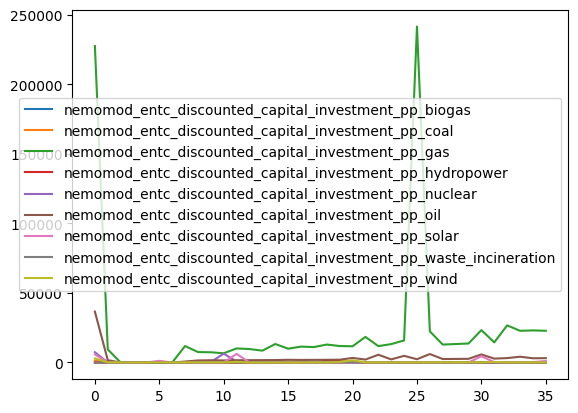

In [220]:

df_prim = df_outputs
df_in_cur = df_inputs


fields_plot = [
    x for x in df_prim.columns
    if "investment" in x
    and df_prim[x].max() > 0
]
(
    df_prim[fields_plot]
    .plot(
        legend = True,
    )
)




In [139]:
matt.extract_model_variable(
    df_out_raw,
    "Energy Demand by Fuel in SCOE"#Industrial Energy"
).iloc[7]

energy_demand_enfu_subsector_total_pj_scoe_fuel_biofuels                      0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_biogas                        0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_biomass                     546.753417
energy_demand_enfu_subsector_total_pj_scoe_fuel_coal                         78.779258
energy_demand_enfu_subsector_total_pj_scoe_fuel_coke                          0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_crude                         0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_diesel                      662.233684
energy_demand_enfu_subsector_total_pj_scoe_fuel_electricity                3556.017787
energy_demand_enfu_subsector_total_pj_scoe_fuel_furnace_gas                   0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_gasoline                     82.779210
energy_demand_enfu_subsector_total_pj_scoe_fuel_geothermal                    0.000000
energy_demand_enfu_subsector_total_pj_scoe_

In [131]:
dict_files.keys()

dict_keys(['transport total final consumption by source', 'industry total final consumption by source', 'total final energy consumption', 'commercial and public services total final consumption by source', 'residential total final consumption by source', 'electricity generation sources'])

In [138]:
df = dict_files.get("industry total final consumption by source")
df = dict_files.get("commercial and public services total final consumption by source")
df2 = dict_files.get("residential total final consumption by source")
df[df["Year"].isin([2022])]["Value"].sum()/1000 + df2[df2["Year"].isin([2022])]["Value"].sum()/1000

3258.703

##  Build MSP

In [98]:


"""


df_electricity_generation_share_g = (
    df_electricity_generation_share
    .groupby(["Year", ])
)


data_electricity_generation_share = do.DatasetIEA(
    df_electricity_generation_share
)
"""
build_msp(dict_files)["Fuel"].unique()


#df_electricity_generation_share["Value"] = df_electricity_generation_share["Value"]/df_electricity_generation_share["Value"].sum()
#df_electricity_generation_share

#data_electricity_generation_share.df

array(['Coal', 'Oil', 'Natural gas', 'Nuclear', 'Hydro', 'Biofuels',
       'Wind', 'Solar PV'], dtype=object)

True

In [99]:
matt.get_attribute_table("Energy Technology")

,category_name,cat_technology,description,data_source,hyperlink,notes,operational_life,technology_from_storage,technology_to_storage,electricity_generation_cat_fuel,cat_storage,generates_fuel_cat_fuel,fuel_processing,mining_and_extraction,power_plant,storage,renewable_default
0,Fuel Production - Ammonia,fp_ammonia_production,Ammonia production using the Haber-Bosch proce...,NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
1,Fuel Production - Hydrogen Electrolysis,fp_hydrogen_electrolysis,"Hydrogen generation from electrolysis, which r...",NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
2,Fuel Production - Hydrogen from Coal Gasification,fp_hydrogen_gasification,Hydrogen generation from fossil-fuel driven th...,NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
3,Fuel Production - Hydrogen Steam Methane Refor...,fp_hydrogen_reformation,Hydrogen generation from steam-methane reforma...,NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
4,Fuel Production - Hydrogen Steam Methane Refor...,fp_hydrogen_reformation_ccs,Hydrogen generation from steam-methane reforma...,NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
5,Fuel Production - Natural Gas,fp_natural_gas,"Natural gas processing, which refines unproces...",NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
6,Fuel Production - Petroleum Refinement,fp_petroleum_refinement,"Oil refinery technology, which produce inputs ...",NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
7,Mining and Exploration - Coal,me_coal,Coal mining and extraction; produces ``fuel_co...,NaN,NaN,NaN,100,none,none,none,none,``fuel_coal``,0,1,0,0,0
8,Mining and Exploration - Crude,me_crude,Crude oil exploration and extraction; produces...,NaN,NaN,NaN,100,none,none,none,none,``fuel_crude``,0,1,0,0,0
9,Mining and Exploration - Natural Gas,me_natural_gas,Natural gas exploration and extraction; produc...,NaN,NaN,NaN,100,none,none,none,none,``fuel_natural_gas_unprocessed``,0,1,0,0,0


In [60]:
#df_electricity_generation_share
dir(data_electricity_generation_share)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_initialize_data_frame',
 '_initialize_fields',
 '_initialize_melt_fields',
 '_initialize_reader_specification',
 '_subset',
 'df',
 'dict_field_definition',
 'field_keys',
 'field_units',
 'field_value',
 'field_year',
 'fields',
 'fields_integer',
 'file_read_specification',
 'get_integer_fields',
 'get_subset',
 'melt_by_subset',
 'read']

In [49]:
importlib.reload(sdp)

<module 'sisepuede_data_pipeline' (<_frozen_importlib_external.NamespaceLoader object at 0x1031f4810>)>